In [33]:
# imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import itertools
import math 
import statistics
from itertools import permutations
import json
import time
import joblib

# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)

In [34]:
# cd '/content/gdrive/MyDrive/Colab Notebooks/vis-2-assignment'

In [35]:
cars = pd.read_csv("data/cars/cars.csv", index_col=0)

In [36]:
cars = cars[cars.horsepower != "?"]

In [47]:
cars.drop('car_name', axis=1, inplace=True)

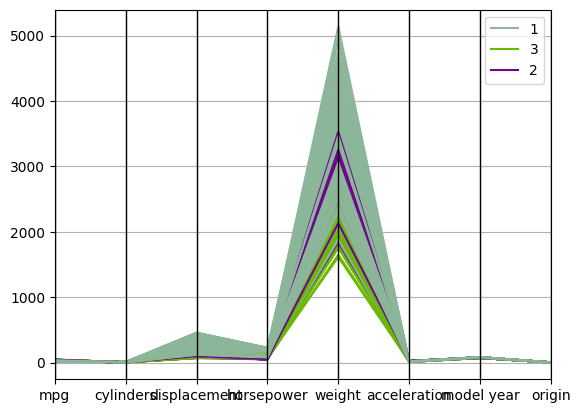

In [50]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

parallel_coordinates(cars, class_column='origin', cols=cars.columns.tolist())

plt.show()

## FS1

In [5]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

def calculate_FS1_for_each_column(df,group_label):
    
    col = df.columns
    colu = []
    for c in col:
        if (isfloat(df[c][0])):
            colu.append(c)
            
    for c in colu:
        df[c] = df[c].astype(float)
    
    string_columns_float = list(df.select_dtypes(exclude=['object']).columns)
    string_columns_object = list(df.select_dtypes(include=['object']).columns)
    
    # print(f"Group label is: {group_label}")
    # print(f"Group label has {len(df[group_label].unique())} unique values")
    no_of_datasets = len(df[group_label].unique())
    df = df.drop(labels=string_columns_object,axis=1)
    list_of_datasets = []
    origin_dict = {}
    dict_of_mean_values = {} #key is the origin and the values are list of means for each column of a datas

    #creating separated datasetst for each group
    for count,value in enumerate(df[group_label].unique()):
        list_of_datasets.append( df[df[group_label] == value])
        list_of_datasets[count] = list_of_datasets[count].reset_index()
    
    
    #drop origin column for each group and save it as a key in dictionary where 
    #the value of the key will be the corresponding dataset
    
    for dataset in list_of_datasets:
        
        group = int(dataset[group_label].unique()[0])
        
        origin_dict[group] = dataset.drop(labels=[group_label],axis=1)
        
        columns = origin_dict[group].columns
        scaler = MinMaxScaler()
        scaler.fit(origin_dict[group])
        origin_dict[group] = scaler.transform(origin_dict[group])
        origin_dict[group] = pd.DataFrame(origin_dict[group], columns = columns)
        origin_dict[group] = origin_dict[group].drop(labels=["index"] ,axis=1)
        dict_of_mean_values[group] = [origin_dict[group][c].mean() for c in origin_dict[group].columns]
        
    #calculation of diff and QDS between each combination of the groups.
    diff = []

    for key1, key2 in itertools.combinations(dict_of_mean_values.keys(), 2):
        diff.append(abs(np.subtract(np.array(dict_of_mean_values[key1]),np.array(dict_of_mean_values[key2]))))
            
    #creation of the matrix W
    D = origin_dict[1].shape[1]
    W = np.ones((D, D))
    
    for row in range(len(W)):
        for col in range(len(W[0])):
            dij = abs(row-col)
            W[row][col] = 1 - (dij/(D-1))
            
    #calculating QFD
    QFD = []
    for count,d in enumerate(diff):
        QFD.append(math.sqrt(np.dot(np.dot(d,W),np.transpose(d))))
        
    tds = statistics.mean(QFD)
    
    return tds

In [6]:
print(calculate_FS1_for_each_column(cars,"origin"))

0.6268655640398301


# FS2

In [7]:
# FS2 funkcija

def calculate_FS2_for_each_column(df, group_label):
    
    col = df.columns
    colu = []
    for c in col:
        if (isfloat(df[c][0])):
            colu.append(c)
            
    for c in colu:
        df[c] = df[c].astype(float)
    
    string_columns_float = list(df.select_dtypes(exclude=['object']).columns)
    string_columns_object = list(df.select_dtypes(include=['object']).columns)
    
    # print(f"Group label is: {group_label}")
    # print(f"Group label has {len(df[group_label].unique())} unique values")
    no_of_datasets = len(df[group_label].unique())
    df = df.drop(labels=string_columns_object,axis=1)
    list_of_datasets = []
    origin_dict = {}
    dict_of_mean_values = {} #key is the origin and the values are list of means for each column of a datas
    dict_of_std_values_minus = {}
    dict_of_std_values_plus = {}
    final_dict = {}

    #creating separated datasetst for each group
    for count,value in enumerate(df[group_label].unique()):
        list_of_datasets.append( df[df[group_label] == value])
        list_of_datasets[count] = list_of_datasets[count].reset_index()
    
    
    #drop origin column for each group and save it as a key in dictionary where 
    #the value of the key will be the corresponding dataset
    
    for dataset in list_of_datasets:
        
        group = int(dataset[group_label].unique()[0])
        
        origin_dict[group] = dataset.drop(labels=[group_label],axis=1)
        
        columns = origin_dict[group].columns
        scaler = MinMaxScaler()
        scaler.fit(origin_dict[group])
        origin_dict[group] = scaler.transform(origin_dict[group])
        origin_dict[group] = pd.DataFrame(origin_dict[group], columns = columns)
        origin_dict[group] = origin_dict[group].drop(labels=["index"] ,axis=1)
        dict_of_std_values_minus[group] = [origin_dict[group][c].mean() - origin_dict[group][c].std() for c in origin_dict[group].columns]
        dict_of_mean_values[group] = [origin_dict[group][c].mean() for c in origin_dict[group].columns]
        dict_of_std_values_plus[group] = [origin_dict[group][c].mean() + origin_dict[group][c].std() for c in origin_dict[group].columns]
        matrix = np.array([dict_of_std_values_minus[group], dict_of_mean_values[group], dict_of_std_values_plus[group]])
        final_dict[group] = matrix
        
    #calculation of diff and QDS between each combination of the groups.
    diff = []

    for key1, key2 in itertools.combinations(final_dict.keys(), 2):
        diff.append(abs(np.subtract(np.array(final_dict[key1]),np.array(final_dict[key2]))))
            
    #creation of the matrix W
    D = origin_dict[1].shape[1]
    W = np.ones((D, D))
        
    for row in range(len(W)):
        for col in range(len(W[0])):
            dij = abs(row-col)
            W[row][col] = 1 - (dij/(D-1))
            
    # print(diff)
                        
    #calculating QFD
    QFD = []
    for count,d in enumerate(diff):
        # print(d.shape)
        # print(W.shape)
        QFD.append(np.sqrt(np.dot(np.dot(d,W),np.transpose(d))))
            
    TDS = sum(QFD)/len(QFD)
    TDS = sum(TDS)/len(TDS)
    TDS = sum(TDS)/len(TDS)
    
    return TDS

In [8]:
print(calculate_FS2_for_each_column(cars,"origin"))

0.625254807610549


# FS3 

In [9]:
# FS3 funkcija

def calc_hist(numbers):
    range_0_2 = 0
    range_2_4 = 0
    range_4_6 = 0
    range_6_8 = 0
    range_8_10 = 0

    # Iterate through the numbers and count occurrences in each range
    for number in numbers:
        if 0 <= number < 0.2:
            range_0_2 += 1
        elif 0.2 <= number < 0.4:
            range_2_4 += 1
        elif 0.4 <= number < 0.6:
            range_4_6 += 1
        elif 0.6 <= number < 0.8:
            range_6_8 += 1
        elif 0.8 <= number <= 1.0:
            range_8_10 += 1

    ranges = [range_0_2, range_2_4, range_4_6, range_6_8, range_8_10]
    
    return(np.array(ranges))

def calculate_FS3_for_each_column(df, group_label):
    
    col = df.columns    
    
    colu = []
    for c in col:
        if (isfloat(df[c][0])):
            colu.append(c)
            
    for c in colu:
        df[c] = df[c].astype(float)
    
    string_columns_float = list(df.select_dtypes(exclude=['object']).columns)
    string_columns_object = list(df.select_dtypes(include=['object']).columns)
    
    # print(f"Group label is: {group_label}")
    # print(f"Group label has {len(df[group_label].unique())} unique values")
    no_of_datasets = len(df[group_label].unique())
    df = df.drop(labels=string_columns_object,axis=1)
    list_of_datasets = []
    origin_dict = {}
    final_dict = {}

    #creating separated datasetst for each group
    for count,value in enumerate(df[group_label].unique()):
        list_of_datasets.append( df[df[group_label] == value])
        list_of_datasets[count] = list_of_datasets[count].reset_index()
    
    
    #drop origin column for each group and save it as a key in dictionary where 
    #the value of the key will be the corresponding dataset
    
    for dataset in list_of_datasets:
        
        group = int(dataset[group_label].unique()[0])
        
        origin_dict[group] = dataset.drop(labels=[group_label],axis=1)
        
        columns = origin_dict[group].columns
        scaler = MinMaxScaler()
        scaler.fit(origin_dict[group])
        origin_dict[group] = scaler.transform(origin_dict[group])
        origin_dict[group] = pd.DataFrame(origin_dict[group], columns = columns)
        origin_dict[group] = origin_dict[group].drop(labels=["index"] ,axis=1)

        final_dict[group] = [(calc_hist(origin_dict[group][c]) / origin_dict[group][c].shape[0]) for c in origin_dict[group].columns]
        
    #calculation of diff and QDS between each combination of the groups.
    diff = []

    for key1, key2 in itertools.combinations(final_dict.keys(), 2):
        diff.append(abs(np.subtract(np.array(final_dict[key1]),np.array(final_dict[key2]))))
            
    # print(diff)
    
    #creation of the matrix W
    D = len(final_dict[1])
    W = np.ones((D, D))
        
    for row in range(len(W)):
        for col in range(len(W[0])):
            dij = abs(row-col)
            W[row][col] = 1 - (dij/(D-1))
                        
    #calculating QFD
    QFD = []
    for count,d in enumerate(diff):
        # print(W.shape)
        # print(d.shape)
        # QFD.append(np.sqrt(np.dot(np.dot(d,W),np.transpose(d))))
        QFD.append(np.sqrt(np.dot(np.dot(np.transpose(d),W),d)))
        
    TDS = sum(QFD)/len(QFD)
    TDS = sum(TDS)/len(TDS)
    TDS = sum(TDS)/len(TDS)
    
    return TDS

In [10]:
print(calculate_FS3_for_each_column(cars,"origin"))

0.6213322709152201


# Run the combinations for cars - fs1

In [44]:
cars = pd.read_csv("data/cars/cars.csv", index_col=0)

In [45]:
cars = cars[cars.horsepower != "?"]
df = cars.copy()

df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 7]]

In [46]:
og_order = df.columns.tolist()

In [47]:
og_order

['mpg',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model year',
 'car_name',
 'origin']

In [48]:
col_keys = [i for i in range(0, len(df.columns.tolist()))]
col_keys = col_keys[:-1]

In [49]:
tds_list = []
permutations_list = list(permutations(col_keys))
permutations_list = [list(tup) for tup in permutations_list]

permutations_list_names = permutations_list.copy()

for i in range(len(permutations_list)):
    permutations_list_names[i] = [og_order[index] for index in permutations_list[i]]
    permutations_list_names[i].append('class')

In [50]:
for i in range(len(permutations_list)):
    permutations_list[i].append(8)

In [51]:
def run_parallel(i):

    subset = df.iloc[:, permutations_list[i]]
    return(calculate_FS1_for_each_column(subset,"origin"))

In [52]:
# original_function

for i in range(len(permutations_list)):
    subset = df.iloc[:, permutations_list[i]]
    tds_list.append(calculate_FS1_for_each_column(subset,"origin"))

In [ ]:
# tds_list = joblib.Parallel(n_jobs=-1)(joblib.delayed(run_parallel)(i) for i in range(len(permutations_list)))

In [55]:
# the resulting dictionary along with the actual column names
result_cars_cols = {
    index: {"columns_order": permutations_list_names[index], "tds": tds_list[index]}
    for index, _ in enumerate(permutations_list_names)
}

# the resulting dictionary along with the indexes of the column names as was ordered in the original ordering
result_cars_indexes = {
    index: {"columns_order": permutations_list[index], "tds": tds_list[index]}
    for index, _ in enumerate(permutations_list)
}

In [ ]:
# result_cars_cols

In [ ]:
# result_cars_indexes

In [58]:
file_path = 'results/cars/result_cars_cols.json'

with open(file_path, "w") as json_file:
    json.dump(result_cars_cols, json_file)

In [59]:
file_path = 'results/cars/result_cars_indexes.json'

with open(file_path, "w") as json_file:
    json.dump(result_cars_indexes, json_file)

# Getting the columns order of the best and the worst for data set 1 - Cars

In [2]:
# get the best and worst ordering for the final dash application

# Open the JSON file
with open('results/cars/result_cars_indexes.json') as file:
    # Load the JSON data into a dictionary
    result_cars_indexes = json.load(file)

In [3]:
result_cars_indexes

{'0': {'columns_order': [0, 1, 2, 3, 4, 5, 6, 7, 8],
  'tds': 0.6268655640398301},
 '1': {'columns_order': [0, 1, 2, 3, 4, 5, 7, 6, 8],
  'tds': 0.6268655640398301},
 '2': {'columns_order': [0, 1, 2, 3, 4, 6, 5, 7, 8],
  'tds': 0.6281926796012295},
 '3': {'columns_order': [0, 1, 2, 3, 4, 6, 7, 5, 8],
  'tds': 0.6281926796012295},
 '4': {'columns_order': [0, 1, 2, 3, 4, 7, 5, 6, 8],
  'tds': 0.6268655640398301},
 '5': {'columns_order': [0, 1, 2, 3, 4, 7, 6, 5, 8],
  'tds': 0.6281926796012295},
 '6': {'columns_order': [0, 1, 2, 3, 5, 4, 6, 7, 8],
  'tds': 0.6245461049189803},
 '7': {'columns_order': [0, 1, 2, 3, 5, 4, 7, 6, 8],
  'tds': 0.6245461049189803},
 '8': {'columns_order': [0, 1, 2, 3, 5, 6, 4, 7, 8],
  'tds': 0.6226624099832957},
 '9': {'columns_order': [0, 1, 2, 3, 5, 6, 7, 4, 8],
  'tds': 0.6226624099832957},
 '10': {'columns_order': [0, 1, 2, 3, 5, 7, 4, 6, 8],
  'tds': 0.6245461049189803},
 '11': {'columns_order': [0, 1, 2, 3, 5, 7, 6, 4, 8],
  'tds': 0.6226624099832957},
 '

In [4]:
max_key = max(result_cars_indexes, key=lambda k: result_cars_indexes[k]['tds'])
min_key = min(result_cars_indexes, key=lambda k: result_cars_indexes[k]['tds'])

print("Key with maximum tds value:", max_key)
print("Key with minimum tds value:", min_key)

Key with maximum tds value: 1208
Key with minimum tds value: 6488


In [5]:
result_cars_indexes[max_key]

{'columns_order': [0, 2, 6, 1, 4, 5, 3, 7, 8], 'tds': 0.6783763578943595}

In [63]:
best_ordering = result_cars_indexes[max_key]['columns_order']
best_ordering.remove(8)

In [65]:
df['origin'].unique()

array([1, 3, 2], dtype=int64)

In [69]:
cars_1 = df[df['origin'] == 1].copy()

In [70]:
cars_2 = df[df['origin'] == 2].copy()

In [71]:
cars_3 = df[df['origin'] == 3].copy()

In [73]:
cars_1.drop('origin', axis=1, inplace=True)
cars_2.drop('origin', axis=1, inplace=True)
cars_3.drop('origin', axis=1, inplace=True)

In [79]:
cars_1_best = cars_1.iloc[:, best_ordering].copy()
cars_2_best = cars_2.iloc[:, best_ordering].copy()
cars_3_best = cars_3.iloc[:, best_ordering].copy()

In [6]:
result_cars_indexes[min_key]

{'columns_order': [1, 3, 0, 2, 5, 6, 4, 7, 8], 'tds': 0.590184316024716}

In [84]:
worst_ordering = result_cars_indexes[min_key]['columns_order']
worst_ordering.remove(8)

In [85]:
cars_1_worst = cars_1.iloc[:, worst_ordering].copy()
cars_2_worst = cars_2.iloc[:, worst_ordering].copy()
cars_3_worst = cars_3.iloc[:, worst_ordering].copy()

In [89]:
cars_1_best.to_csv('results/cars/orderings-data-sets/cars_1_best.csv')
cars_2_best.to_csv('results/cars/orderings-data-sets/cars_2_best.csv')
cars_3_best.to_csv('results/cars/orderings-data-sets/cars_3_best.csv')
cars_1_worst.to_csv('results/cars/orderings-data-sets/cars_1_worst.csv')
cars_2_worst.to_csv('results/cars/orderings-data-sets/cars_2_worst.csv')
cars_3_worst.to_csv('results/cars/orderings-data-sets/cars_3_worst.csv')

# Run the combinations for glass data set - fs2

In [2]:
glass = pd.read_csv("data/glass/glass.csv", index_col=0)

In [3]:
df = glass.copy()
df.drop('id', axis=1, inplace=True)

In [4]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type_of_glass
0,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
1,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
2,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
3,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
4,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1


In [33]:
og_order = df.columns.tolist()

In [34]:
col_keys = [i for i in range(0, len(df.columns.tolist()))]
col_keys = col_keys[:-1]

In [35]:
tds_list = []
permutations_list = list(permutations(col_keys))
permutations_list = [list(tup) for tup in permutations_list]

permutations_list_names = permutations_list.copy()

for i in range(len(permutations_list)):
    permutations_list_names[i] = [og_order[index] for index in permutations_list[i]]
    permutations_list_names[i].append('type_of_glass')

In [36]:
for i in range(len(permutations_list)):
    permutations_list[i].append(9)

In [37]:
# calculate how much time it would take to perform the function_2 on the entire glass data set
"""
permutations_list = permutations_list[:1000]
permutations_list_names = permutations_list_names[:1000]

og_length = len(permutations_list)

permutations_list = permutations_list[:1000]

permutations_list_names = permutations_list.copy()

for i in range(len(permutations_list)):
    permutations_list_names[i] = [og_order[index] for index in permutations_list[i]]

start_time = time.time()
tds_list = joblib.Parallel(n_jobs=-1)(joblib.delayed(run_parallel_2)(i) for i in range(len(permutations_list)))
end_time = time.time()

time_takes = (end_time - start_time) * (og_length / 1000)

print(time_takes)"""

'\npermutations_list = permutations_list[:1000]\npermutations_list_names = permutations_list_names[:1000]\n\nog_length = len(permutations_list)\n\npermutations_list = permutations_list[:1000]\n\npermutations_list_names = permutations_list.copy()\n\nfor i in range(len(permutations_list)):\n    permutations_list_names[i] = [og_order[index] for index in permutations_list[i]]\n\nstart_time = time.time()\ntds_list = joblib.Parallel(n_jobs=-1)(joblib.delayed(run_parallel_2)(i) for i in range(len(permutations_list)))\nend_time = time.time()\n\ntime_takes = (end_time - start_time) * (og_length / 1000)\n\nprint(time_takes)'

In [38]:
def run_parallel_2(i):

    subset = df.iloc[:, permutations_list[i]]
    return(calculate_FS2_for_each_column(subset,"type_of_glass"))

In [ ]:
started - 19:41

In [48]:
# original_code

for i in range(len(permutations_list)):    
    subset = df.iloc[:, permutations_list[i]]
    tds_list.append(calculate_FS2_for_each_column(subset,"type_of_glass"))
    
    left = len(permutations_list) - i
 
    print("\r{}".format(left), end="")

100000

In [50]:
len(tds_list)

365028

In [ ]:
estimated end time - 22:10

In [51]:
# the resulting dictionary along with the actual column names
result_glass_cols = {
    index: {"columns_order": permutations_list_names[index], "tds": tds_list[index]}
    for index, _ in enumerate(permutations_list_names)
}

# the resulting dictionary along with the indexes of the column names as was ordered in the original ordering
result_glass_indexes = {
    index: {"columns_order": permutations_list[index], "tds": tds_list[index]}
    for index, _ in enumerate(permutations_list)
}

In [197]:
# result_glass_cols

In [198]:
# result_glass_indexes

In [52]:
file_path = 'results/glass/result_glass_indexes.json'

with open(file_path, "w") as json_file:
    json.dump(result_glass_indexes, json_file)
    
file_path = 'results/glass/result_glass_cols.json'

with open(file_path, "w") as json_file:
    json.dump(result_glass_cols, json_file)

# Getting the columns order of the best and the worst for data set 2 - glass

In [10]:
with open('results/glass/result_glass_indexes.json') as file:
    # Load the JSON data into a dictionary
    result_glass_indexes = json.load(file)

In [13]:
max_key = max(result_glass_indexes, key=lambda k: result_glass_indexes[k]['tds'])
min_key = min(result_glass_indexes, key=lambda k: result_glass_indexes[k]['tds'])

print("Key with maximum tds value:", max_key)
print("Key with minimum tds value:", min_key)

Key with maximum tds value: 157260
Key with minimum tds value: 84751


In [14]:
result_glass_indexes[max_key]

{'columns_order': [3, 8, 1, 4, 5, 6, 0, 2, 7, 9], 'tds': 1.6022949416448065}

In [15]:
best_ordering = result_glass_indexes[max_key]['columns_order']

In [16]:
df['type_of_glass'].unique()

array([1, 2, 3, 5, 6, 7], dtype=int64)

In [17]:
glass_1 = df[df['type_of_glass'] == 1].copy()
glass_2 = df[df['type_of_glass'] == 2].copy()
glass_3 = df[df['type_of_glass'] == 3].copy()
glass_5 = df[df['type_of_glass'] == 5].copy()
glass_6 = df[df['type_of_glass'] == 6].copy()
glass_7 = df[df['type_of_glass'] == 7].copy()

In [18]:
glass_1.drop('type_of_glass', axis=1, inplace=True)
glass_2.drop('type_of_glass', axis=1, inplace=True)
glass_3.drop('type_of_glass', axis=1, inplace=True)
glass_5.drop('type_of_glass', axis=1, inplace=True)
glass_6.drop('type_of_glass', axis=1, inplace=True)
glass_7.drop('type_of_glass', axis=1, inplace=True)

In [20]:
best_ordering.remove(9)

In [21]:
glass_1_best = glass_1.iloc[:, best_ordering].copy()
glass_2_best = glass_2.iloc[:, best_ordering].copy()
glass_3_best = glass_3.iloc[:, best_ordering].copy()
glass_5_best = glass_5.iloc[:, best_ordering].copy()
glass_6_best = glass_6.iloc[:, best_ordering].copy()
glass_7_best = glass_7.iloc[:, best_ordering].copy()

In [22]:
result_glass_indexes[min_key]

{'columns_order': [2, 0, 7, 6, 3, 4, 1, 8, 5, 9], 'tds': 1.473352411195025}

In [23]:
worst_ordering = result_glass_indexes[min_key]['columns_order']

In [24]:
worst_ordering.remove(9)

In [25]:
glass_1_worst = glass_1.iloc[:, worst_ordering].copy()
glass_2_worst = glass_2.iloc[:, worst_ordering].copy()
glass_3_worst = glass_3.iloc[:, worst_ordering].copy()
glass_5_worst = glass_5.iloc[:, worst_ordering].copy()
glass_6_worst = glass_6.iloc[:, worst_ordering].copy()
glass_7_worst = glass_7.iloc[:, worst_ordering].copy()

In [26]:
glass_1_worst.to_csv('results/glass/orderings-data-sets/glass_1_worst.csv')
glass_2_worst.to_csv('results/glass/orderings-data-sets/glass_2_worst.csv')
glass_3_worst.to_csv('results/glass/orderings-data-sets/glass_3_worst.csv')
glass_5_worst.to_csv('results/glass/orderings-data-sets/glass_5_worst.csv')
glass_6_worst.to_csv('results/glass/orderings-data-sets/glass_6_worst.csv')
glass_7_worst.to_csv('results/glass/orderings-data-sets/glass_7_worst.csv')

In [27]:
glass_1_best.to_csv('results/glass/orderings-data-sets/glass_1_best.csv')
glass_2_best.to_csv('results/glass/orderings-data-sets/glass_2_best.csv')
glass_3_best.to_csv('results/glass/orderings-data-sets/glass_3_best.csv')
glass_5_best.to_csv('results/glass/orderings-data-sets/glass_5_best.csv')
glass_6_best.to_csv('results/glass/orderings-data-sets/glass_6_best.csv')
glass_7_best.to_csv('results/glass/orderings-data-sets/glass_7_best.csv')

# Run the combinations for seeds data set - fs3

In [ ]:
seeds = pd.read_csv("data/seeds/seeds.csv", index_col=0)

In [ ]:
df = seeds.copy()

In [ ]:
df.head()

In [ ]:
og_order = df.columns.tolist()

In [ ]:
og_order

In [ ]:
col_keys = [i for i in range(0, len(df.columns.tolist()))]
col_keys = col_keys[:-1]

In [ ]:
tds_list = []
permutations_list = list(permutations(col_keys))
permutations_list = [list(tup) for tup in permutations_list]

permutations_list_names = permutations_list.copy()

for i in range(len(permutations_list)):
    permutations_list_names[i] = [og_order[index] for index in permutations_list[i]]
    permutations_list_names[i].append('class')

In [ ]:
for i in range(len(permutations_list)):
    permutations_list[i].append(7)

In [ ]:
def run_parallel_3(i):

    subset = df.iloc[:, permutations_list[i]]
    return(calculate_FS3_for_each_column(subset,"class"))

In [ ]:
"""# calculate how much time it would take to perform the function_2 on the entire glass data set

og_length = len(permutations_list)

permutations_list = permutations_list[:1000]

permutations_list_names = permutations_list.copy()

for i in range(len(permutations_list)):
    permutations_list_names[i] = [og_order[index] for index in permutations_list[i]]

start_time = time.time()
tds_list = joblib.Parallel(n_jobs=-1)(joblib.delayed(run_parallel_3)(i) for i in range(len(permutations_list)))
end_time = time.time()

time_takes = (end_time - start_time) * (og_length / 1000)

print(time_takes)"""

In [ ]:
# original_code

for cols_ordering in permutations_list:
    subset = df.iloc[:, cols_ordering]
    tds_list.append(calculate_FS3_for_each_column(subset,"class"))

In [ ]:
# the resulting dictionary along with the actual column names
result_seeds_cols = {
    index: {"columns_order": permutations_list_names[index], "tds": tds_list[index]}
    for index, _ in enumerate(permutations_list_names)
}

# the resulting dictionary along with the indexes of the column names as was ordered in the original ordering
result_seeds_indexes = {
    index: {"columns_order": permutations_list[index], "tds": tds_list[index]}
    for index, _ in enumerate(permutations_list)
}

In [ ]:
# result_seeds_cols

In [ ]:
len(result_seeds_cols)

In [ ]:
len(result_seeds_indexes)

In [ ]:
file_path = 'results/seeds/result_seeds_cols.json'

with open(file_path, "w") as json_file:
    json.dump(result_seeds_cols, json_file)

In [ ]:
file_path = 'results/seeds/result_seeds_indexes.json'

with open(file_path, "w") as json_file:
    json.dump(result_seeds_indexes, json_file)

# Getting the columns order of the best and the worst for data set 3

In [8]:
# get the best and worst ordering for the final dash application

# Open the JSON file
with open('results/seeds/result_seeds_indexes.json') as file:
    # Load the JSON data into a dictionary
    result_seeds_indexes = json.load(file)

In [9]:
result_seeds_indexes

{'0': {'columns_order': [0, 1, 2, 3, 4, 5, 6], 'tds': 0.4182978566134955},
 '1': {'columns_order': [0, 1, 2, 3, 4, 6, 5], 'tds': 0.41969333567997175},
 '2': {'columns_order': [0, 1, 2, 3, 5, 4, 6], 'tds': 0.4170259097019192},
 '3': {'columns_order': [0, 1, 2, 3, 5, 6, 4], 'tds': 0.416263107054616},
 '4': {'columns_order': [0, 1, 2, 3, 6, 4, 5], 'tds': 0.41931768881458104},
 '5': {'columns_order': [0, 1, 2, 3, 6, 5, 4], 'tds': 0.41713543325304114},
 '6': {'columns_order': [0, 1, 2, 4, 3, 5, 6], 'tds': 0.41816406127804406},
 '7': {'columns_order': [0, 1, 2, 4, 3, 6, 5], 'tds': 0.4195509598634378},
 '8': {'columns_order': [0, 1, 2, 4, 5, 3, 6], 'tds': 0.42095108502341405},
 '9': {'columns_order': [0, 1, 2, 4, 5, 6, 3], 'tds': 0.42822201850427594},
 '10': {'columns_order': [0, 1, 2, 4, 6, 3, 5], 'tds': 0.4229849318448558},
 '11': {'columns_order': [0, 1, 2, 4, 6, 5, 3], 'tds': 0.4288696643303284},
 '12': {'columns_order': [0, 1, 2, 5, 3, 4, 6], 'tds': 0.41656645922089297},
 '13': {'columns

In [10]:
max_key = max(result_seeds_indexes, key=lambda k: result_seeds_indexes[k]['tds'])
min_key = min(result_seeds_indexes, key=lambda k: result_seeds_indexes[k]['tds'])

print("Key with maximum tds value:", max_key)
print("Key with minimum tds value:", min_key)

Key with maximum tds value: 808
Key with minimum tds value: 3120


In [11]:
result_seeds_indexes[max_key]

{'columns_order': [1, 0, 5, 4, 6, 2, 3], 'tds': 0.4345727485543593}

In [ ]:
best_ordering = result_seeds_indexes[max_key]['columns_order']

In [ ]:
df['class'].unique()

In [ ]:
seeds_1 = df[df['class'] == 1].copy()

In [ ]:
seeds_2 = df[df['class'] == 2].copy()

In [ ]:
seeds_3 = df[df['class'] == 3].copy()

In [ ]:
seeds_1.drop('class', axis=1, inplace=True)
seeds_2.drop('class', axis=1, inplace=True)
seeds_3.drop('class', axis=1, inplace=True)

In [ ]:
seeds_1_best = seeds_1.iloc[:, best_ordering].copy()
seeds_2_best = seeds_2.iloc[:, best_ordering].copy()
seeds_3_best = seeds_3.iloc[:, best_ordering].copy()

In [12]:
result_seeds_indexes[min_key]

{'columns_order': [4, 2, 0, 1, 3, 5, 6], 'tds': 0.401919672665923}

In [ ]:
worst_ordering = result_seeds_indexes[min_key]['columns_order']

In [ ]:
seeds_1_worst = seeds_1.iloc[:, worst_ordering].copy()
seeds_2_worst = seeds_2.iloc[:, worst_ordering].copy()
seeds_3_worst = seeds_3.iloc[:, worst_ordering].copy()

In [ ]:
seeds_1_worst.to_csv('results/seeds/orderings-data-sets/seeds_1_worst.csv')
seeds_2_worst.to_csv('results/seeds/orderings-data-sets/seeds_2_worst.csv')
seeds_3_worst.to_csv('results/seeds/orderings-data-sets/seeds_3_worst.csv')
seeds_1_best.to_csv('results/seeds/orderings-data-sets/seeds_1_best.csv')
seeds_2_best.to_csv('results/seeds/orderings-data-sets/seeds_2_best.csv')
seeds_3_best.to_csv('results/seeds/orderings-data-sets/seeds_3_best.csv')